In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
import json
 
default = {'scenario': 'houston','project':'houston','training_folder':'../../scenarios'} # Default execution parameters
manual, argv = (True, default) if 'ipykernel' in sys.argv[0] else (False, dict(default, **json.loads(sys.argv[1])))


In [2]:
import os
import time
import geopandas as gpd
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
sys.path.insert(0, r'../../../quetzal') # Add path to quetzal
from sklearn.neighbors import NearestNeighbors
from numba import jit, njit
import numba as nb
from quetzal.model import stepmodel
from shapely.geometry import LineString
from quetzal.io.gtfs_reader.importer import get_epsg
from quetzal.io import excel
from syspy.skims.skims import euclidean
from syspy.syspy_utils.pandas_utils import groupby_weighted_average
on_lambda = bool(os.environ.get('AWS_EXECUTION_ENV'))
num_cores = nb.config.NUMBA_NUM_THREADS
print('num cores:',num_cores)

io_engine= 'pyogrio' if on_lambda else 'pyogrio' #or fiona

PyTables is not installed. No support for HDF output.
num cores: 8


In [3]:
scenario = argv['scenario']

base_folder = os.path.join(argv['training_folder'],argv['scenario'])
input_folder = os.path.join(base_folder,'inputs/')
pt_folder  = os.path.join(input_folder,'pt/')
road_folder = os.path.join(input_folder,'road/')
params_folder = input_folder if on_lambda else '../../inputs/'
calib_folder = os.path.join(input_folder,'calibration/')

output_folder = os.path.join(base_folder,'outputs/')
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
model_folder = os.path.join(base_folder, 'model/')


In [4]:
od = pd.read_csv(calib_folder + 'OD.csv')
all_columns = pd.read_csv(calib_folder + 'all_columns.csv')
blocks_fix = gpd.read_file(calib_folder + 'blocks_fix.geojson')
part_modale = gpd.read_file(calib_folder + 'part_modale.geojson')

In [5]:
'''
# 71, 401, 863, 864, 1688 dallas
# 205, 554, 628, 1058 atlanta
# 86, 93, 94, 180, 329, 330, 671, 734, 1441, 1563 houston

all_columns.drop([0,86, 93, 94, 329, 330, 671, 734, 1441, 1563], inplace= True)
all_columns.to_csv(input_folder + 'all_columns.csv')
'''


"\n# 71, 401, 863, 864, 1688 dallas\n# 205, 554, 628, 1058 atlanta\n# 86, 93, 94, 180, 329, 330, 671, 734, 1441, 1563 houston\n\nall_columns.drop([0,86, 93, 94, 329, 330, 671, 734, 1441, 1563], inplace= True)\nall_columns.to_csv(input_folder + 'all_columns.csv')\n"

In [6]:
#find ratio PPAM/ALL_PERIOD
all_columns['PPAM'] = all_columns[['S0801_C01_030E', 'S0801_C01_031E', 'S0801_C01_032E', 'S0801_C01_033E', 'S0801_C01_034E', 'S0801_C01_035E']].astype(float).sum(axis=1)
all_columns ['ALL_PERIOD'] = all_columns[['S0801_C02_027E','S0801_C02_028E','S0801_C02_029E', 'S0801_C01_030E', 'S0801_C01_031E', 'S0801_C01_032E', 'S0801_C01_033E', 'S0801_C01_034E', 'S0801_C01_035E', 'S0801_C02_036E']].astype(float).sum(axis=1)
all_columns['GEOID'] = all_columns['GEO_ID'].apply(lambda x: x[9:]).astype(float)

GENERATION/DISTRIBUTION

Data preparation

In [7]:
od['volumes'] = od[['S000', 'SA01', 'SA02', 'SA03', 'SE01','SE02', 'SE03', 'SI01', 'SI02', 'SI03']].sum(axis = 1)

In [8]:
part_modale = part_modale.loc[~part_modale['Geography'].isna()]
part_modale['County'] = part_modale['Geography'].apply(lambda x: x[11:14])
part_modale['TRACTCE20'] = part_modale['Geography'].apply(lambda x: x[-6:])

part_modale.to_file(calib_folder + 'part_modale_county.geojson')

block_to_tract = blocks_fix[['GEOID20', 'TRACTCE20']]

block_name_tract = part_modale[['TRACTCE20', 'NAME', 'County']].merge(block_to_tract, on = 'TRACTCE20',  how='right')
block_name_tract = block_name_tract.drop_duplicates(['NAME', 'GEOID20'])



In [9]:
block_name_tract['GEOID20_2'] = block_name_tract['GEOID20'].astype(str).apply(lambda x : x[0:11]).astype(float)
block_name_tract = block_name_tract.merge(all_columns[['GEOID', 'PPAM', 'ALL_PERIOD']], left_on= 'GEOID20_2', right_on='GEOID', how='left')
block_name_tract = block_name_tract.drop(['GEOID20_2','GEOID'], axis=1)
block_name_tract['part_PPAM'] = block_name_tract['PPAM']/block_name_tract['ALL_PERIOD']


Volumes model

In [10]:
sm = stepmodel.read_zippedpickles(model_folder + 'distribution')
sm_network = stepmodel.read_zippedpickles(model_folder + 'network')
sm.zones =sm_network.zones
sm.zones_before_clustering.set_index('cluster', inplace= True)
sm._add_type_prefixes({'zones_before_clustering':'zone_'})
sm.zones_before_clustering['index'] = sm.zones_before_clustering.index

zones: 100%|██████████| 26/26 [00:01<00:00, 14.84it/s]                  


In [11]:
sm.volumes = sm.volumes.fillna(0)
sm.volumes['volumes'] = sm.volumes['car_owner'] + sm.volumes['pt_captive']
sm.volumes.drop_duplicates(['origin', 'destination'])

,origin,destination,car_owner,pt_captive,volumes
0,zone_174,zone_488,0.000000,0.001,0.001000
1,zone_488,zone_4,0.000000,0.001,0.001000
9,zone_446,zone_83,0.000000,0.001,0.001000
8,zone_239,zone_443,0.000000,0.001,0.001000
7,zone_386,zone_300,0.000000,0.001,0.001000
...,...,...,...,...,...
77732,zone_99,zone_81,25.061892,0.000,25.061892
77733,zone_99,zone_87,25.020056,0.000,25.020056
77734,zone_99,zone_9,25.000259,0.000,25.000259
77735,zone_99,zone_90,75.068889,0.000,75.068889


In [12]:
def ratio_par_zones(self):
    
    df = self.copy()
    df["ratio"] = df["population"] / df["population"].sum()
    
    return(df[["ratio", 'NAME']])

In [13]:
sm.zones_before_clustering = (sm.zones_before_clustering.groupby('NAME').apply(ratio_par_zones))#.droplevel(1)
sm.zones_before_clustering['index'] = sm.zones_before_clustering.index
zones = sm.zones_before_clustering

Volumes calibration

In [14]:
od_tract= od.merge(block_name_tract[['NAME', 'GEOID20', 'County','part_PPAM']], left_on= 'w_geocode', right_on= 'GEOID20', how = 'left')
od_tract = od_tract.merge(block_name_tract[['NAME', 'GEOID20', 'County']],left_on= 'h_geocode', right_on= 'GEOID20', how = 'left', suffixes= ('_origin', '_destination'))
od_tract = od_tract.loc[~od_tract['NAME_destination'].isna()][['NAME_origin', 'NAME_destination', 'volumes', 'County_origin', 'County_destination', 'part_PPAM']]
od_tract = od_tract.groupby(['NAME_origin', 'NAME_destination']).agg({'volumes': 'sum', 'County_origin': 'first' , 'County_destination' : 'first', 'part_PPAM': 'first'}).reset_index()

od_tract = od_tract.merge(sm.zones_before_clustering[['index', 'NAME', 'ratio']], left_on=  'NAME_origin', right_on= 'NAME', how = 'left')
od_tract = od_tract.merge(sm.zones_before_clustering[['index', 'NAME', 'ratio']], left_on=  'NAME_destination', right_on= 'NAME', how = 'left' , suffixes = ('_origin', '_destination'))

#mult ratios
od_tract['volumes'] = od_tract['volumes']*(od_tract['ratio_origin'] * od_tract['ratio_destination']) #####

#od_tract = od_tract.drop(['NAME_origin', 'NAME_destination'], axis = 1)

od_zones = od_tract.groupby(['index_origin', 'index_destination' ], as_index=False).agg({'volumes': 'sum', 'part_PPAM': 'first', 'County_origin':'first', 'County_destination': 'first'} )
od_zones.rename(columns={'index_origin': 'origin', 'index_destination': 'destination'}, inplace = True)
od_zones['volumes_PPAM'] = od_zones['part_PPAM']*od_zones['volumes']
#od_tract.drop_duplicates(['origin', 'destination'])


In [15]:
print(' Calibration:'+ od_zones['volumes_PPAM'].sum().astype(str) + '\n','Model:'+ sm.volumes['volumes'].sum().astype(str) + '\n','Rapport Calibration/Model:' + (od_zones['volumes_PPAM'].sum()/sm.volumes['volumes'].sum()).astype(str) + '\n' )

 Calibration:6042857.518292366
 Model:4645890.273530428
 Rapport Calibration/Model:1.3006888158166459



Volumes comparison 

In [16]:
def GEH(A, B):
    return ((2*(A-B)**2)/(A+B)).apply(math.sqrt)

In [17]:
comp_volumes = od_zones.merge(sm.volumes[['origin', 'destination','volumes']], on = ['origin', 'destination'], how= 'inner', suffixes= ('_calibration', '_model'))
comp_volumes_macro = comp_volumes.groupby(['County_origin', 'County_destination'], as_index=False).sum()

In [18]:
comp_volumes[['volumes_PPAM', 'volumes_model']].sum()

volumes_PPAM     3.063691e+06
volumes_model    3.752291e+06
dtype: float64

In [19]:
comp_volumes

,origin,destination,volumes_calibration,part_PPAM,County_origin,County_destination,volumes_PPAM,volumes_model
0,zone_0,zone_1,12.0,0.558612,201,201,6.703349,25.075870
1,zone_0,zone_103,12.0,0.567539,201,201,6.810471,25.075870
2,zone_0,zone_104,16.0,0.471959,201,201,7.551337,150.455217
3,zone_0,zone_107,12.0,0.471959,201,039,5.663503,25.075870
4,zone_0,zone_109,12.0,0.546053,201,201,6.552632,100.109555
...,...,...,...,...,...,...,...,...
57267,zone_99,zone_65,4.0,0.584259,167,157,2.337037,50.133122
57268,zone_99,zone_81,36.0,0.468616,167,167,16.870163,25.061892
57269,zone_99,zone_9,12.0,0.739754,167,201,8.877049,25.000259
57270,zone_99,zone_90,8.0,0.584259,167,201,4.674074,75.068889


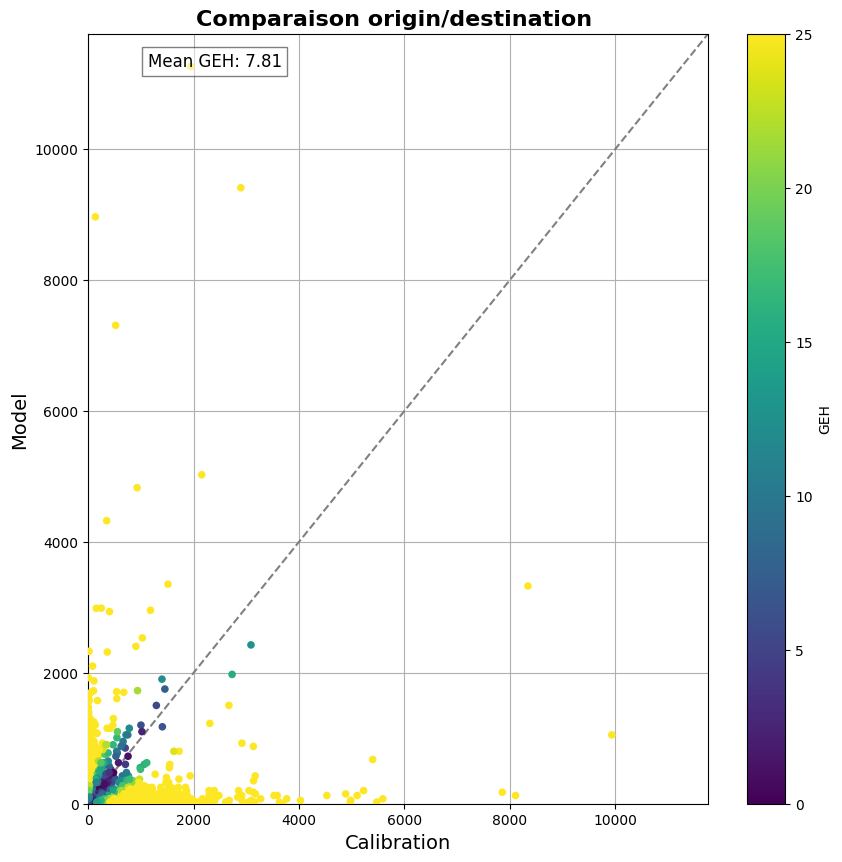

In [20]:
to_plot = comp_volumes.set_index(['origin', 'destination'])
ycol= 'volumes_model'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_PPAM']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+500])
plt.ylabel('Model', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison origin/destination ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

Volumes comparison - distance

In [21]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return math.ceil(n * multiplier) / multiplier

In [22]:
origins = sm.volumes['origin'].unique().tolist()
destinations = sm.volumes['destination'].unique().tolist()

distances = euclidean(sm.zones, coordinates_unit='meter', epsg=4326, origins=origins, destinations=destinations)
distances['euclidean_distance'] = (distances['euclidean_distance']/1000).apply(lambda x: round_up(x,-1))
distances = distances[['origin', 'destination', 'euclidean_distance']]


In [23]:
comp_volumes_dist= comp_volumes.merge(distances, on = ['origin','destination'] , how= 'left' )
comp_volumes_dist = comp_volumes_dist.groupby('euclidean_distance')['volumes_PPAM', 'volumes_model'].sum()

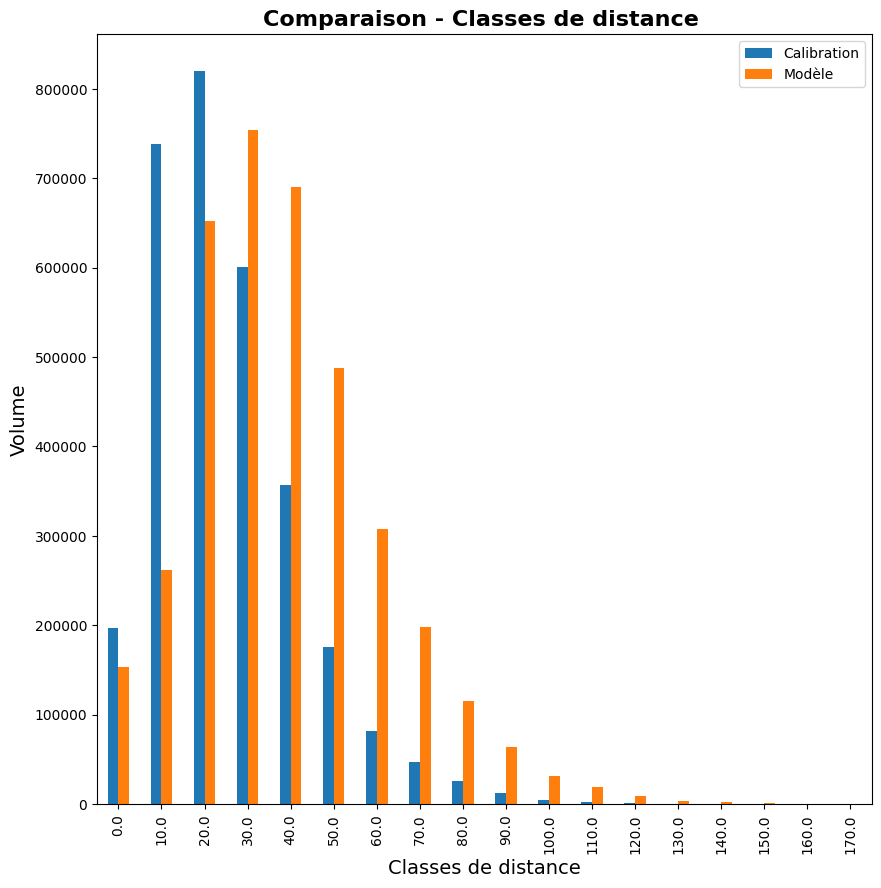

In [25]:
comp_volumes_dist.plot( kind = 'bar', figsize=[10, 10])
plt.ylabel('Volume', fontsize=14)
plt.xlabel('Classes de distance', fontsize=14)
plt.title('Comparaison - Classes de distance ', loc='center', fontsize=16, fontweight="bold")
plt.legend(['Calibration', 'Modèle'])
fig = ax.get_figure()


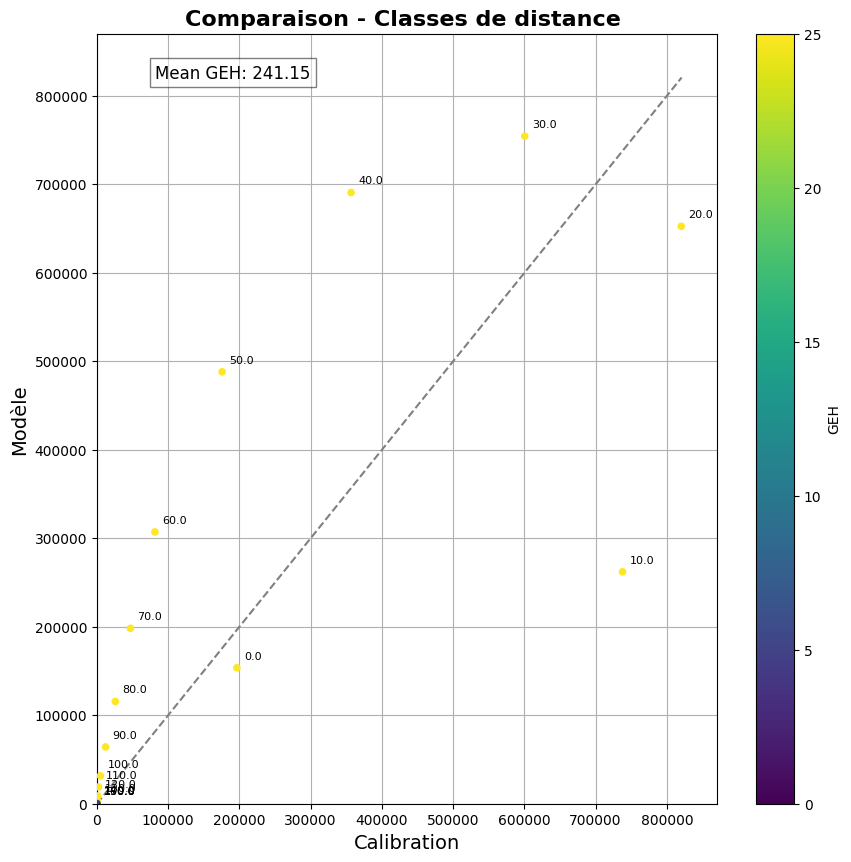

In [26]:
to_plot = comp_volumes_dist
ycol= 'volumes_model'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

to_plot['label'] = to_plot.index
to_plot[['x_label','y_label']] = to_plot[[xcol,ycol]] +10000
to_plot[['x_label','y_label','label']].apply(lambda x: ax.text(*x, fontsize=8),axis=1)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_PPAM']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylabel('Modèle', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison - Classes de distance ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

In [27]:
#TODO histogramme avec indicateur de dispersion (earth mover distance)

Volumes comparison - Macro OD

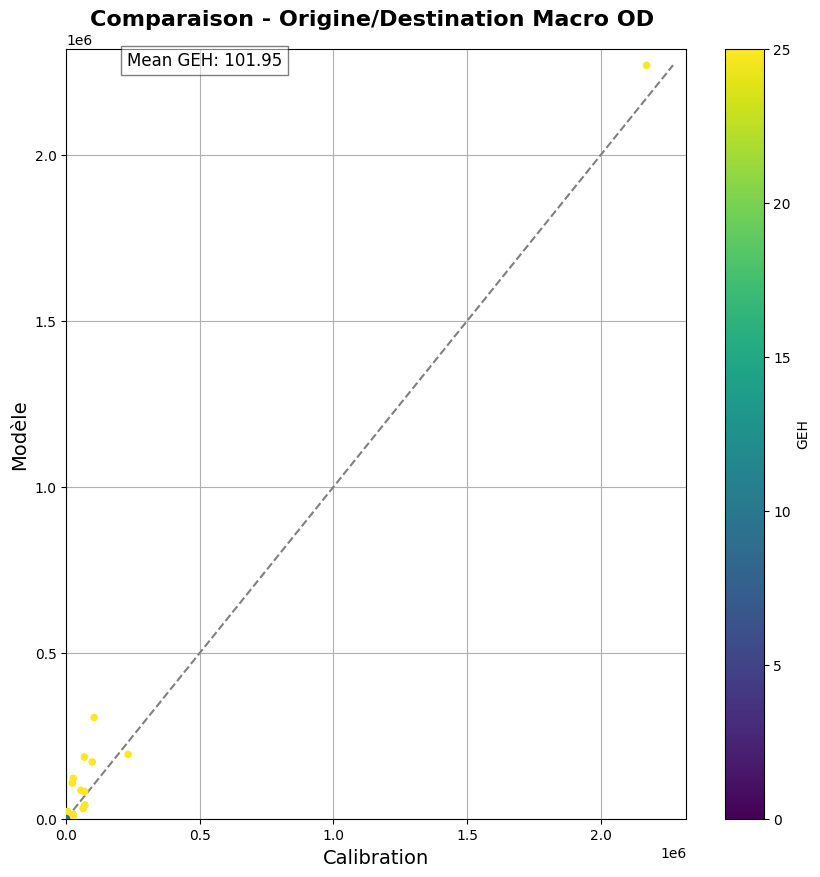

In [28]:
to_plot = comp_volumes_macro.set_index(['County_origin', 'County_destination'])
ycol= 'volumes_model'
xcol= 'volumes_PPAM'
to_plot['GEH'] = GEH(to_plot['volumes_model'], to_plot['volumes_PPAM'])
ax =  to_plot.plot.scatter(x=xcol, y=ycol, c='GEH', figsize=[10, 10], zorder=3, cmap='viridis', vmin=0, vmax=25)

#to_plot['is_labeled'] = (abs(to_plot[xcol] -to_plot[ycol]) > 940)
#to_plot.loc[to_plot['is_labeled'],'label'] = to_plot.loc[to_plot['is_labeled']].index
#to_plot[['x_label','y_label']] = to_plot[[xcol,ycol]] +10000
#to_plot[['x_label','y_label','label']].apply(lambda x: ax.text(*x, fontsize=12),axis=1)

stats = True
if stats:
    meanGEH = to_plot['GEH'].mean()
    mvol = to_plot[['volumes_model','volumes_PPAM']].max().max()
    plt.text(0.1*mvol, mvol,
                        'Mean GEH: {e}'.format(e=np.round(meanGEH, 2)), fontsize = 12,
                        bbox = dict(facecolor = 'white', alpha = 0.5))

t = np.arange(0., max(to_plot[xcol].max(),to_plot[ycol].max()) +500, 1)
plt.plot(t,t,linestyle='--',color="Grey", zorder=2)
plt.xlim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylim([0., max(to_plot[xcol].max(),to_plot[ycol].max())+50000])
plt.ylabel('Modèle', fontsize=14)
plt.xlabel('Calibration', fontsize=14)
ax.grid(axis='both', zorder=3)
plt.title('Comparaison - Origine/Destination Macro OD ', loc= 'center', fontsize=16, fontweight="bold")
fig = ax.get_figure()
#fig.savefig('../../outputs/plot/%s/%s/%s.png' % (scenario+'_'+period_s,zone, 'boardings_bus'), bbox_inches='tight', dpi=150)

LOGIT

In [29]:
sm = stepmodel.read_zippedpickles(model_folder + 'logit_assignment')
sm.zones_before_clustering = zones

loaded_links: 100%|██████████| 43/43 [00:08<00:00,  5.07it/s]   


Data preparation

In [30]:
part_modale['car'] = part_modale['Estimate_Car, truck, or van']
part_modale['pt'] = part_modale['Estimate_Public transportation (excluding taxicab)']
part_modale['walk'] = part_modale['Estimate_Walked'] + part_modale['Estimate_Bicycle']
part_modale = part_modale.loc[~part_modale['Geography'].isna()]
part_modale['County'] = part_modale['Geography'].apply(lambda x: x[11:14])
part_modale['TRACTCE20'] = part_modale['Geography'].apply(lambda x: x[-6:])

block_to_tract = blocks_fix[['GEOID20', 'TRACTCE20']]

block_name_tract = part_modale[['TRACTCE20', 'NAME', 'County', 'car', 'pt', 'walk']].merge(block_to_tract, on = 'TRACTCE20',  how='right')
block_name_tract = block_name_tract.drop_duplicates(['NAME', 'GEOID20'])


In [31]:
block_name_tract['GEOID20_2'] = block_name_tract['GEOID20'].astype(str).apply(lambda x : x[0:11]).astype(float)
block_name_tract = block_name_tract.merge(all_columns[['GEOID', 'PPAM', 'ALL_PERIOD']], left_on= 'GEOID20_2', right_on='GEOID', how='left')
block_name_tract = block_name_tract.drop(['GEOID20_2','GEOID'], axis=1)
block_name_tract['part_PPAM'] = block_name_tract['PPAM']/block_name_tract['ALL_PERIOD']

In [32]:
sm.los.loc[sm.los['route_type'] == 'car']['volume'].sum(), sm.los.loc[sm.los['route_type'] != 'car']['volume'].sum()

(4523312.004561983, 122578.26896844518)

In [33]:
los = sm.los[['origin', 'destination','route_type', 'volume']]
los = los.groupby(['origin', 'route_type']).sum()
los = los.unstack('route_type')['volume']
los.columns = los.columns.values
los['volume'] = los.sum(axis=1)
los['pt'] = los[list(set(los.columns) - {'car', 'walk', 'volume'})].sum(axis=1)

los['part_car'] = los['car']/los[['car', 'pt', 'walk']].sum(axis=1) 
los['part_pt'] = los['pt']/los[['car', 'pt', 'walk']].sum(axis=1) 
los['part_walk'] = los['walk']/los[['car', 'pt', 'walk']].sum(axis=1) 

part_model = groupby_weighted_average(los, 'origin', ['part_car', 'part_pt', 'part_walk'], 'volume')

In [34]:
part_model

,part_car,part_pt,part_walk
origin,,,
zone_0,0.977551,0.021194,0.001255
zone_1,0.983758,0.002870,0.013372
zone_10,0.997809,0.000000,0.002191
zone_100,0.980011,0.000000,0.019989
zone_101,1.000000,0.000000,0.000000
...,...,...,...
zone_95,0.997254,0.000000,0.002746
zone_96,0.913371,0.000000,0.086629
zone_97,0.996365,0.000000,0.003635


In [35]:
zones_part_modale = block_name_tract.merge(sm.zones_before_clustering[['index', 'NAME', 'ratio']], on=  'NAME', how = 'left')
zones_part_modale['part_car'] = zones_part_modale['car']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 
zones_part_modale['part_pt'] = zones_part_modale['pt']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 
zones_part_modale['part_walk'] = zones_part_modale['walk']/zones_part_modale[['car', 'pt', 'walk']].sum(axis=1) 

part_calibration = groupby_weighted_average(zones_part_modale, 'index', ['part_car', 'part_pt', 'part_walk'], 'PPAM')

In [36]:
zones_part_modale

,TRACTCE20,NAME,County,car,pt,walk,GEOID20,PPAM,ALL_PERIOD,part_PPAM,index,ratio,part_car,part_pt,part_walk,"(part_car, PPAM)","(part_pt, PPAM)","(part_walk, PPAM)"
0,341203,Census Tract 3412.03,201,88.9,3.4,0.6,4.820134e+14,75.0,95.4,0.786164,zone_160,1.0,0.956943,0.036598,0.006459,71.770721,2.744887,0.484392
1,673600,Census Tract 6736,157,81.3,1.8,0.0,4.815767e+14,73.3,97.8,0.749489,zone_458,1.0,0.978339,0.021661,0.000000,71.712274,1.587726,0.000000
2,220800,Census Tract 2208,201,74.8,12.4,0.0,4.820122e+14,69.7,97.7,0.713408,zone_172,1.0,0.857798,0.142202,0.000000,59.788532,9.911468,0.000000
3,230400,Census Tract 2304,201,90.1,6.7,0.0,4.820123e+14,42.3,89.9,0.470523,zone_343,1.0,0.930785,0.069215,0.000000,39.372211,2.927789,0.000000
4,230200,Census Tract 2302,201,89.9,1.1,1.6,4.820123e+14,58.0,97.4,0.595483,zone_343,1.0,0.970842,0.011879,0.017279,56.308855,0.688985,1.002160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82704,722200,Census Tract 7222,167,76.4,2.8,9.4,4.816772e+14,58.2,98.9,0.588473,zone_210,1.0,0.862302,0.031603,0.106095,50.186005,1.839278,6.174718
82705,722200,Census Tract 7222,167,76.4,2.8,9.4,4.816772e+14,58.2,98.9,0.588473,zone_210,1.0,0.862302,0.031603,0.106095,50.186005,1.839278,6.174718
82706,722100,Census Tract 7221,167,99.8,0.0,0.0,4.816772e+14,42.8,99.4,0.430584,zone_498,1.0,1.000000,0.000000,0.000000,42.800000,0.000000,0.000000
82707,722002,Census Tract 7220.02,167,84.5,6.5,6.9,4.816772e+14,53.9,101.7,0.529990,zone_210,1.0,0.863126,0.066394,0.070480,46.522472,3.578652,3.798876


In [37]:
comp_part_modale = part_calibration.merge(part_model, left_index=True, right_index=True, suffixes=('_calibration', '_model'))

comp_part_modale_macro = comp_part_modale.merge(zones_part_modale[['index', 'County', 'PPAM']], left_index=True, right_on='index')

In [38]:
comp_part_modale_macro = groupby_weighted_average(comp_part_modale_macro, 'County', ['part_car_calibration', 'part_pt_calibration', 'part_walk_calibration', 'part_car_model', 'part_pt_model', 'part_walk_model'], 'PPAM')

In [39]:
comp_part_modale_macro

,part_car_calibration,part_pt_calibration,part_walk_calibration,part_car_model,part_pt_model,part_walk_model
County,,,,,,
039,0.990762,0.001860,0.007378,0.993199,0.000032,0.006768
071,0.995614,0.000000,0.004386,1.000000,0.000000,0.000000
157,0.981931,0.010644,0.007425,0.987015,0.001193,0.011791
167,0.956468,0.006461,0.037071,0.985626,0.000050,0.014324
201,0.955743,0.023272,0.020985,0.962507,0.014912,0.022581
339,0.978057,0.008998,0.012944,0.981082,0.000023,0.018895
473,0.996333,0.003667,0.000000,0.996789,0.000000,0.003211


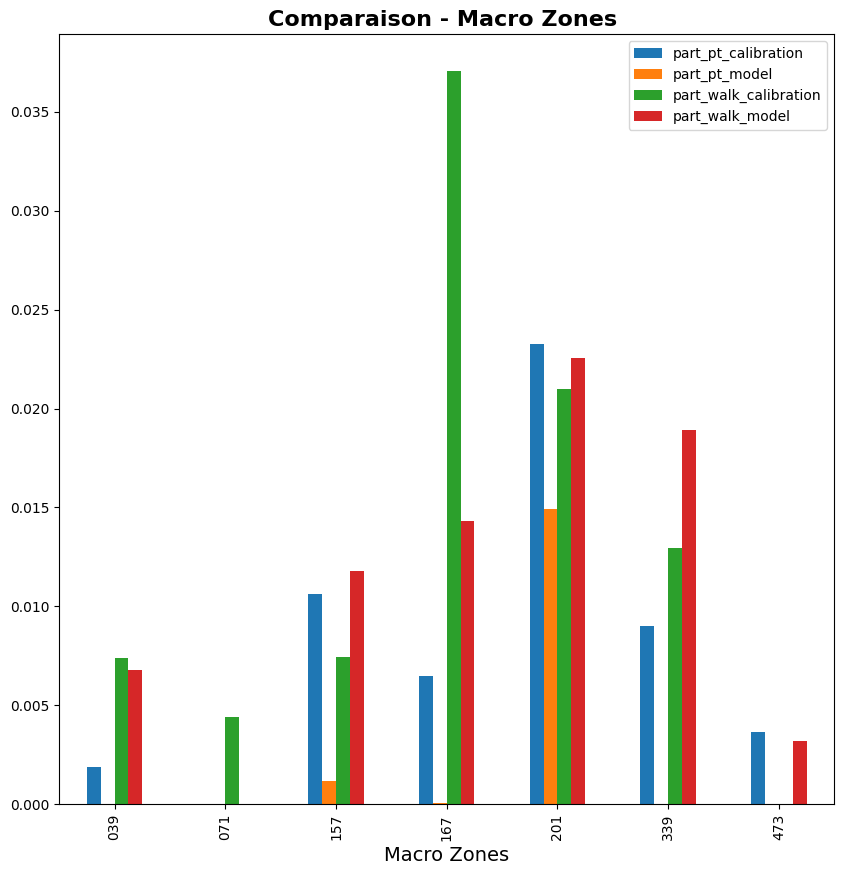

In [40]:
comp_part_modale_macro[['part_pt_calibration','part_pt_model','part_walk_calibration','part_walk_model']].plot( kind = 'bar', figsize=[10, 10])
plt.xlabel('Macro Zones', fontsize=14)
plt.title('Comparaison - Macro Zones ', loc='center', fontsize=16, fontweight="bold")
fig = ax.get_figure()


PATHFINDER

In [41]:
sm.pt_los['route_type'].unique()

array(['bus', 'tram', 'walk'], dtype=object)

In [42]:
volumes_modes = sm.pt_los[['origin', 'destination','route_type', 'volume']]
volumes_modes.groupby('route_type')['volume'].sum()

route_type
bus     37035.095793
tram     3811.179072
walk    81731.994103
Name: volume, dtype: float64